In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

BASE = Path("/content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad")

OBJ_BASE = BASE / "object"
OBJ_IMG_DIR = OBJ_BASE / "data_object_image_2" / "training" / "image_2"
OBJ_LBL_DIR = OBJ_BASE / "data_object_label_2" / "training" / "label_2"

ROAD_BASE = BASE / "road" / "data_road" / "training"
ROAD_IMG_DIR = ROAD_BASE / "image_2"
ROAD_GT_DIR  = ROAD_BASE / "gt_image_2"

print("OBJ_IMG_DIR:", OBJ_IMG_DIR, "exists:", OBJ_IMG_DIR.exists())
print("OBJ_LBL_DIR:", OBJ_LBL_DIR, "exists:", OBJ_LBL_DIR.exists())
print("ROAD_IMG_DIR:", ROAD_IMG_DIR, "exists:", ROAD_IMG_DIR.exists())
print("ROAD_GT_DIR :", ROAD_GT_DIR,  "exists:", ROAD_GT_DIR.exists())


Mounted at /content/drive
OBJ_IMG_DIR: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/data_object_image_2/training/image_2 exists: True
OBJ_LBL_DIR: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/data_object_label_2/training/label_2 exists: True
ROAD_IMG_DIR: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/road/data_road/training/image_2 exists: True
ROAD_GT_DIR : /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/road/data_road/training/gt_image_2 exists: True


In [9]:
def list_files(p: Path, exts=(".png", ".jpg", ".jpeg", ".txt")):
    if not p.exists():
        return []
    out = []
    for e in exts:
        out += list(p.glob(f"*{e}"))
    return sorted(out)

obj_imgs = sorted(OBJ_IMG_DIR.glob("*.png"))
obj_lbls = sorted(OBJ_LBL_DIR.glob("*.txt"))

print("Object images:", len(obj_imgs))
print("Object labels:", len(obj_lbls))
print("Example image:", obj_imgs[0].name if obj_imgs else None)
print("Example label:", obj_lbls[0].name if obj_lbls else None)

if len(obj_lbls) == 0:
    print("\n[WARN] No .txt in expected label dir. Searching for *.txt under object...")
    candidates = list(OBJ_BASE.rglob("*.txt"))
    print("Found txt:", len(candidates))
    print("Example paths:")
    for p in candidates[:10]:
        print("  ", p)



Object images: 7497
Object labels: 7481
Example image: 000000.png
Example label: 000000.txt


In [13]:
from pathlib import Path
from collections import Counter
import pandas as pd
from PIL import Image



print("OBJ_IMG_DIR exists:", OBJ_IMG_DIR.exists(), OBJ_IMG_DIR)
print("OBJ_LBL_DIR exists:", OBJ_LBL_DIR.exists(), OBJ_LBL_DIR)

def list_images(img_dir: Path):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.webp"]
    imgs = []
    for e in exts:
        imgs += list(img_dir.glob(e))
    return sorted(imgs)

KITTI_IGNORE = {"DontCare"}
MAP_TO_3 = True

def normalize_kitti_class(cls: str) -> str:
    if not MAP_TO_3:
        return cls
    if cls in {"Car", "Van", "Truck", "Tram"}:
        return "Car"
    if cls in {"Pedestrian", "Person_sitting"}:
        return "Pedestrian"
    if cls in {"Cyclist"}:
        return "Cyclist"
    return "Other"

def parse_kitti_label_file(txt_path: Path):
    out = []
    for line in txt_path.read_text().splitlines():
        if not line.strip():
            continue
        parts = line.split()
        raw_cls = parts[0]
        if raw_cls in KITTI_IGNORE:
            continue
        cls = normalize_kitti_class(raw_cls)

        left, top, right, bottom = map(float, parts[4:8])
        if right <= left or bottom <= top:
            continue

        out.append({"raw_cls": raw_cls, "cls": cls,
                    "left": left, "top": top, "right": right, "bottom": bottom})
    return out

def build_object_image_df(img_dir: Path, lbl_dir: Path, limit=0):
    imgs = list_images(img_dir)
    print("Found images:", len(imgs))
    if limit and limit > 0:
        imgs = imgs[:limit]
        print("Using limit:", len(imgs))

    rows = []
    missing_lbl = 0

    for p in imgs[:3]:
        lp = lbl_dir / (p.stem + ".txt")
        print("sample:", p.name, "label exists:", lp.exists())

    for i, img_path in enumerate(imgs):
        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if not lbl_path.exists():
            missing_lbl += 1
            anns = []
        else:
            anns = parse_kitti_label_file(lbl_path)

        try:
            with Image.open(img_path) as im:
                w, h = im.size
        except Exception as e:
            print("Bad image:", img_path, "err:", e)
            continue

        cls_counts = Counter([a["cls"] for a in anns])
        rows.append({
            "file_name": img_path.name,
            "img_path": str(img_path),
            "lbl_path": str(lbl_path),
            "width": w, "height": h,
            "n_objects": len(anns),
            "class_counts": dict(cls_counts),
            "bboxes": [(a["left"], a["top"], a["right"], a["bottom"], a["cls"]) for a in anns],
        })

        if (i+1) % 500 == 0:
            print(f"processed {i+1}/{len(imgs)} ...")

    df = pd.DataFrame(rows)
    print("Built df rows:", len(df))
    print("Missing label files:", missing_lbl)
    return df

obj_df = build_object_image_df(OBJ_IMG_DIR, OBJ_LBL_DIR, limit=200)
obj_df.head(3)



OBJ_IMG_DIR exists: True /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/data_object_image_2/training/image_2
OBJ_LBL_DIR exists: True /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/data_object_label_2/training/label_2
Found images: 7497
Using limit: 200
sample: 000000.png label exists: True
sample: 000001.png label exists: True
sample: 000002.png label exists: True
Built df rows: 200
Missing label files: 0


,file_name,img_path,lbl_path,width,height,n_objects,class_counts,bboxes
0,000000.png,/content/drive/MyDrive/genai proj Autonomous V...,/content/drive/MyDrive/genai proj Autonomous V...,1224,370,1,{'Pedestrian': 1},"[(712.4, 143.0, 810.73, 307.92, Pedestrian)]"
1,000001.png,/content/drive/MyDrive/genai proj Autonomous V...,/content/drive/MyDrive/genai proj Autonomous V...,1242,375,3,"{'Car': 2, 'Cyclist': 1}","[(599.41, 156.4, 629.75, 189.25, Car), (387.63..."
2,000002.png,/content/drive/MyDrive/genai proj Autonomous V...,/content/drive/MyDrive/genai proj Autonomous V...,1242,375,2,"{'Other': 1, 'Car': 1}","[(804.79, 167.34, 995.43, 327.94, Other), (657..."


from matplotlib import pyplot as plt
_df_0['width'].plot(kind='hist', bins=20, title='width')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['height'].plot(kind='hist', bins=20, title='height')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['n_objects'].plot(kind='hist', bins=20, title='n_objects')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('file_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('img_path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('lbl_path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='width', y='height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='height', y='n_objects', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['width']
  ys = series['n_objects']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('width', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('file_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='file_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('width')
_ = plt.ylabel('n_objects')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['width']
  ys = series['n_objects']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('width', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('img_path')):
  _plot_series(series, series_name, i)
  fig.legend(title='img_path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('width')
_ = plt.ylabel('n_objects')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['width']
  ys = series['n_objects']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('width', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lbl_path')):
  _plot_series(series, series_name, i)
  fig.legend(title='lbl_path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('width')
_ = plt.ylabel('n_objects')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['width']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'width'}, axis=1)
              .sort_values('width', ascending=True))
  xs = counted['width']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('width', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('file_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='file_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('width')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['width'].plot(kind='line', figsize=(8, 4), title='width')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['height'].plot(kind='line', figsize=(8, 4), title='height')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['n_objects'].plot(kind='line', figsize=(8, 4), title='n_objects')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['img_path'].value_counts()
    for x_label, grp in _df_15.groupby('file_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('file_name')
_ = plt.ylabel('img_path')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['lbl_path'].value_counts()
    for x_label, grp in _df_16.groupby('img_path')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('img_path')
_ = plt.ylabel('lbl_path')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['file_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='width', y='file_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['img_path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='width', y='img_path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['lbl_path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='width', y='lbl_path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['file_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='height', y='file_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Images: 200
Avg objects/image: 5.145
Max objects/image: 18


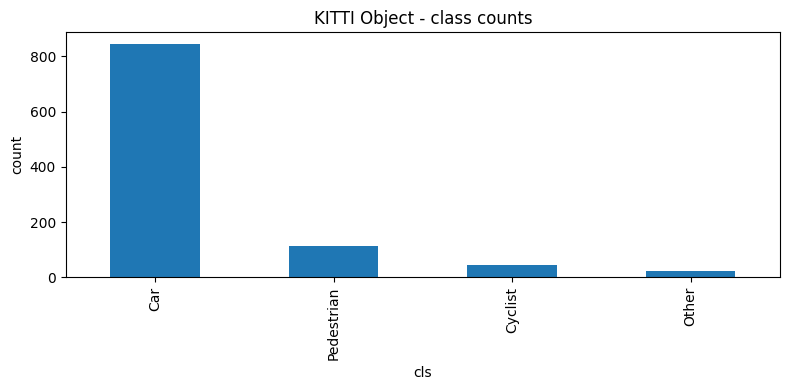

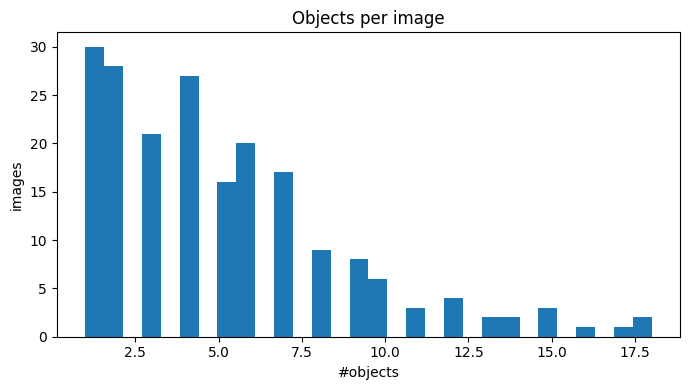

In [17]:
def explode_class_counts(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        cc = r["class_counts"] or {}
        for k, v in cc.items():
            rows.append({"cls": k, "count": v})
    if not rows:
        return pd.DataFrame(columns=["cls", "count"])
    return pd.DataFrame(rows)

def plot_class_counts(df: pd.DataFrame, title="Class counts"):
    cc = explode_class_counts(df)
    if len(cc) == 0:
        print("No annotations to plot.")
        return
    s = cc.groupby("cls")["count"].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    s.plot(kind="bar")
    plt.title(title)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

def plot_objects_per_image(df: pd.DataFrame):
    plt.figure(figsize=(7,4))
    plt.hist(df["n_objects"], bins=30)
    plt.title("Objects per image")
    plt.xlabel("#objects")
    plt.ylabel("images")
    plt.tight_layout()
    plt.show()

print("Images:", len(obj_df))
print("Avg objects/image:", obj_df["n_objects"].mean())
print("Max objects/image:", obj_df["n_objects"].max())

plot_class_counts(obj_df, title="KITTI Object - class counts")
plot_objects_per_image(obj_df)


Total boxes: 1029


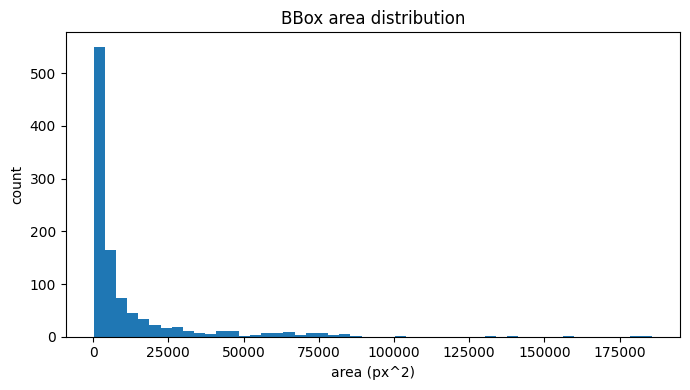

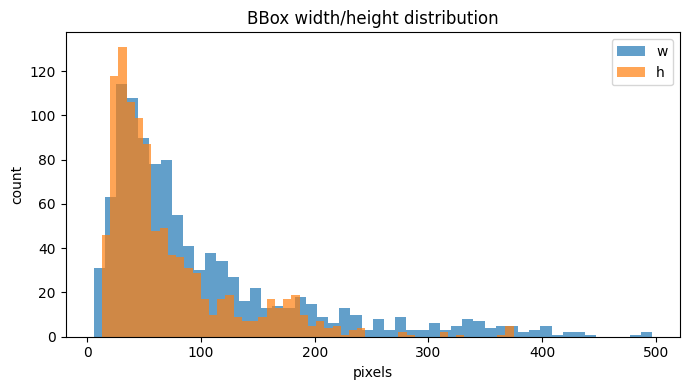

In [18]:
def explode_bboxes(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        for (l,t,rr,b,cls) in (r["bboxes"] or []):
            w = max(0.0, rr-l)
            h = max(0.0, b-t)
            rows.append({
                "file_name": r["file_name"],
                "cls": cls,
                "w": w, "h": h,
                "area": w*h
            })
    return pd.DataFrame(rows)

bbox_df = explode_bboxes(obj_df)
print("Total boxes:", len(bbox_df))
bbox_df.describe()

plt.figure(figsize=(7,4))
plt.hist(bbox_df["area"], bins=50)
plt.title("BBox area distribution")
plt.xlabel("area (px^2)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(bbox_df["w"], bins=50, alpha=0.7, label="w")
plt.hist(bbox_df["h"], bins=50, alpha=0.7, label="h")
plt.title("BBox width/height distribution")
plt.xlabel("pixels")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
def show_image_with_boxes(row, max_boxes=30):
    img = Image.open(row["img_path"]).convert("RGB")
    draw = ImageDraw.Draw(img)
    bbs = row["bboxes"] or []
    for (l,t,r,b,cls) in bbs[:max_boxes]:
        draw.rectangle([l,t,r,b], outline="red", width=2)
        draw.text((l, t), cls, fill="red")
    plt.figure(figsize=(14,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f'{row["file_name"]} | n={len(bbs)}')
    plt.show()

for idx in np.random.choice(len(obj_df), size=min(5, len(obj_df)), replace=False):
    show_image_with_boxes(obj_df.iloc[idx])


Output hidden; open in https://colab.research.google.com to view.